<a href="https://colab.research.google.com/github/AddankiVasavi/Geometric-Feature-Based-Classification-of-Anemia-in-Blood-Smear-Images-Using-Decision-Tree/blob/main/Total_Major.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import os
import joblib
import os

image_path = []
images_folder = "/content/drive/MyDrive/major dataset"

# Check if the directory exists
if os.path.isdir(images_folder):
    # List all files in the directory
    for filename in os.listdir(images_folder):
        # Construct the full path for each image file
        img_path = os.path.join(images_folder, filename)
        # Add the image path to the list
        image_path.append(img_path)
else:
    print("Invalid directory:", images_folder)

def preprocess_image(image):
    magnification_value = 1000
    small_objects_area = magnification_value / 10

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the grayscale image
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Threshold the blurred image to obtain a binary image
    _, binary_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Remove small objects
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < small_objects_area:
            cv2.drawContours(binary_image, [contour], 0, 0, -1)

    # Remove intersected cells
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w >= (magnification_value / 13) or h >= (magnification_value / 13):
            cv2.drawContours(binary_image, [contour], 0, 0, -1)

    # Regions Boundary Tracing
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Remove incomplete objects at the boundary of the image
    image_size = binary_image.shape
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if x < 3 or y < 3 or (x + w) > (image_size[1] - 3) or (y + h) > (image_size[0] - 3):
            cv2.drawContours(binary_image, [contour], 0, 0, -1)

    # Draw contours on the original image
    contour_image = np.copy(image)
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

    return contours

def extract_features(contours):
    features = []
    scale = 0.1
    #spicule_count = len(contours)

    for contour in contours:
        area = cv2.contourArea(contour)
        _, (major_axis, minor_axis), _ = cv2.fitEllipse(contour)
        circularity = major_axis / minor_axis
        x, y, w, h = cv2.boundingRect(contour)
        bounding_box = [x, y, w, h]
        M = cv2.moments(contour)
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
        (x, y), radius = cv2.minEnclosingCircle(contour)
        diameter_pixels = 2 * radius
        diameter_micrometers = diameter_pixels * scale

        features.append({
            "Area": area,
            "Minor Axis Length": round(minor_axis,1),
            "Major Axis Length": round(major_axis,1),
            "Circularity": round(circularity,1),
            #"Bounding Box": bounding_box,
            #"Center": [center_x, center_y],
            "Diameter": round(diameter_micrometers,1),
            #"Spicules Count": spicule_count
        })

    return features

def prepare_feature_matrix(image_path):
    all_features = []
    for image in image_path:
        img = cv2.imread(image)
        c=0
        all_labels = []
        preprocessed_image = preprocess_image(img)
        features = extract_features(preprocessed_image)
        all_features.extend(features)
        # Assuming you have ground truth labels based on image folders
        for features in all_features:
          label = -1
          c=c+1
          area = features["Area"]
          minor_axis = features["Minor Axis Length"]
          major_axis = features["Major Axis Length"]
          circle = features["Circularity"]
          #bounding_box = features["Bounding Box"]
          #center = features["Center"]
          diameter = features["Diameter"]
          #spicule_count = features["Spicules Count"]
          if circle>=0.75 and area>200 and area<2500 and major_axis>25 and major_axis<50 and diameter>3.0 and diameter<4.8:
            label=0
          elif circle>=0.3 and circle<0.75 and area>700 and area<1500 and major_axis>10 and major_axis<35 and diameter>4.5 and diameter<6.5:
            label=1
          elif circle>0.35 and area<1000 and area>100 and diameter>1.0 and diameter<5:
            label=2
          all_labels.append(label)
    print("features",len(all_features))
    print("labels",len(all_labels))
    print("count",c)
    return np.array(all_features), np.array(all_labels)
features_matrix, labels=prepare_feature_matrix(image_path)
for i in range(len(features_matrix)):
  print(features_matrix[i],labels[i])



features 3907
labels 3907
count 3907
{'Area': 314.0, 'Minor Axis Length': 38.9, 'Major Axis Length': 33.2, 'Circularity': 0.9, 'Diameter': 3.3} 0
{'Area': 363.5, 'Minor Axis Length': 35.9, 'Major Axis Length': 33.3, 'Circularity': 0.9, 'Diameter': 3.4} 0
{'Area': 393.5, 'Minor Axis Length': 38.1, 'Major Axis Length': 34.2, 'Circularity': 0.9, 'Diameter': 3.4} 0
{'Area': 354.5, 'Minor Axis Length': 43.6, 'Major Axis Length': 31.1, 'Circularity': 0.7, 'Diameter': 3.4} 2
{'Area': 574.0, 'Minor Axis Length': 38.5, 'Major Axis Length': 31.1, 'Circularity': 0.8, 'Diameter': 3.9} 0
{'Area': 379.5, 'Minor Axis Length': 30.6, 'Major Axis Length': 18.5, 'Circularity': 0.6, 'Diameter': 3.1} 2
{'Area': 841.5, 'Minor Axis Length': 39.6, 'Major Axis Length': 37.8, 'Circularity': 1.0, 'Diameter': 4.1} 0
{'Area': 858.0, 'Minor Axis Length': 33.9, 'Major Axis Length': 32.5, 'Circularity': 1.0, 'Diameter': 3.5} 0
{'Area': 1526.5, 'Minor Axis Length': 73.6, 'Major Axis Length': 38.0, 'Circularity': 0.5, 

In [ ]:
import pandas as pd

column_names = list(features_matrix[0].keys())
df_features = pd.DataFrame(columns=column_names)
for i in range(len(features_matrix)):
    df_features = df_features.append(features_matrix[i], ignore_index=True)

# Add a column for labels
df_features["Label"] = labels

# Save DataFrame to CSV file
csv_filename = "/content/features_and_labels.csv"
df_features.to_csv(csv_filename, index=False)

print("CSV file saved successfully.")


AttributeError: 'DataFrame' object has no attribute 'append'

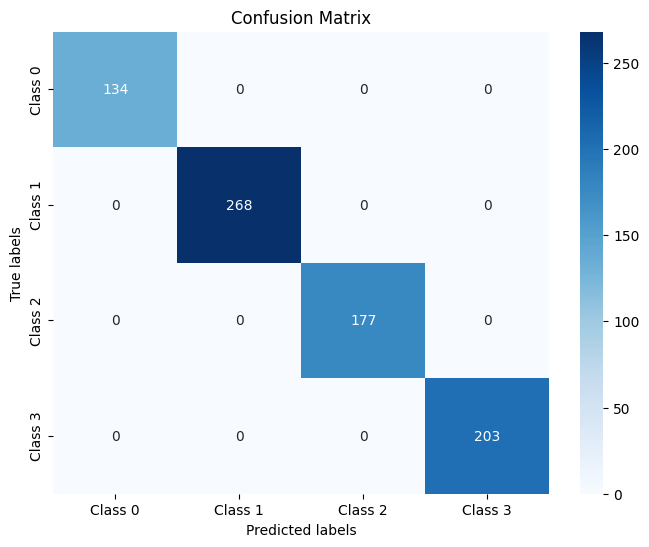

Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00       134
           0       1.00      1.00      1.00       268
           1       1.00      1.00      1.00       177
           2       1.00      1.00      1.00       203

    accuracy                           1.00       782
   macro avg       1.00      1.00      1.00       782
weighted avg       1.00      1.00      1.00       782

Accuracy: 1.0


['/content/model.joblib']

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.models import load_model
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
csv_filename = "/content/features_and_labels.csv"
df = pd.read_csv(csv_filename)

# Step 2: Separate features (input) from labels (output)
X = df.drop(columns=["Label"])  # Features
y = df["Label"]  # Labels

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize classifier
#classifier = SVC(kernel='linear')
classifier = DecisionTreeClassifier()
# Train classifier
classifier.fit(X_train, y_train)

# Predict labels for test set
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1','Class 2','Class 3'], yticklabels=['Class 0', 'Class 1','Class 2','Class 3'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
report = classification_report(y_test, y_pred)

print("Classification Report:\n", report)


# Evaluate classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# Save the trained model to a file
model_filename = "/content/model.joblib"
joblib.dump(classifier, model_filename)

In [ ]:
!pip install gradio


In [ ]:
!pip install tensorflow_addons

In [ ]:
import gradio as gr
import tensorflow as tf
import tensorflow_addons as tfa
import cv2
import numpy as np
import joblib
from collections import Counter
# Define custom metric function
f1_score = tfa.metrics.F1Score(num_classes=3)

# Load saved model
model = joblib.load("/content/model.joblib")

# Define class names for predictions
class_names = {
     -1: 'Unknown',0: 'normal rbc', 1:'elliptocyte', 2:'schistocyte'}

predictions=[]
def classify_image(image):
    preprocessed_image = preprocess_image(image)
    features = extract_features(preprocessed_image)
    keys = list(features[0].keys())
    values = []
    for f in features:
       values.append([f[key] for key in keys])
    numpy_array = np.array(values)
    #apex_frame = apex_frame.reshape((1, 64, 64, 1))  # reshape the array to match the model input shape
    label = model.predict(numpy_array)
    predictions.append(label)
    print(predictions)
    unique, counts = np.unique(predictions, return_counts=True)

    # Find the index of the maximum count
    max_count_index = np.argmax(counts)

    # Print the maximum count and its corresponding unique value
    max_count = counts[max_count_index]
    max_value = unique[max_count_index]
    print(max_value)
    label = class_names[max_value]
    print(f"The maximum count is {max_count} for the value {max_value}.")
    print(label)
    return label
#image="/content/drive/MyDrive/Dataset/738.jpg"
#img = cv2.imread(image)
#print(classify_image(img))
input_component = gr.Image()
output_component = gr.Label(label="Prediction")

interface = gr.Interface(fn=classify_image, inputs=input_component, outputs=output_component, title="Abnormal RBC Classifier")
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://963e8cdcaaa9c533a8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
